# 1. Developing and Saving the Dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import os
import pandas as pd
import segmentation_models_pytorch as smp

In [3]:
PRECOMPUTED_DATA_ROOT = r"C:\Users\manav\KyodaiNaturalResourceLab\dataset"

class PrecomputedNoise2NoiseDataset(Dataset):
    def __init__(self, manifest_file, root_dir):
        self.root_dir = root_dir
        try:
            self.manifest = pd.read_csv(manifest_file)
        except FileNotFoundError:
            print(f"Error: Manifest file not found at {manifest_file}")
            print("Please ensure you have run the data generation phase first.")
            self.manifest = pd.DataFrame() # Empty dataframe

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        if idx >= len(self.manifest):
            raise IndexError("Index out of bounds")
            
        record = self.manifest.iloc[idx]
        
        noisy1_path = os.path.join(self.root_dir, record['noisy1_path'])
        noisy2_path = os.path.join(self.root_dir, record['noisy2_path'])
        clean_path = os.path.join(self.root_dir, record['clean_path'])

        # --- Metadata to return ---
        time_step = record['time_step']
        config_name = record['config_name']
        # --- End Metadata ---

        try:
            noisy1_tensor = torch.load(noisy1_path)
            noisy2_tensor = torch.load(noisy2_path)
            clean_tensor = torch.load(clean_path)
        except FileNotFoundError as e:
            print(f"Error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            # Return dummy metadata as well, or handle appropriately
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config" 
        except Exception as e:
            print(f"Generic error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config"

        # Return tensors and the new metadata
        return noisy1_tensor, noisy2_tensor, clean_tensor, time_step, config_name

In [4]:
manifest_path = os.path.join(PRECOMPUTED_DATA_ROOT, 'manifest.csv')

if not os.path.exists(manifest_path):
    print(f"Manifest file {manifest_path} not found. Please run the data generation phase first.")
    
full_dataset = PrecomputedNoise2NoiseDataset(manifest_file=manifest_path, root_dir=PRECOMPUTED_DATA_ROOT)

train_loader, val_loader, test_loader = None, None, None

if len(full_dataset) > 0:
    total_samples = len(full_dataset)
    indices = list(range(total_samples))
    np.random.shuffle(indices)

    train_ratio = 0.7
    val_ratio = 0.15
    # test_ratio = 0.15 implicitly

    if total_samples < 3:
        train_indices = indices
        val_indices, test_indices = [],[]
    else:
        train_split_idx = int(train_ratio * total_samples)
        val_split_idx = train_split_idx + int(val_ratio * total_samples)
        
        train_indices = indices[:train_split_idx]
        val_indices = indices[train_split_idx:val_split_idx]
        test_indices = indices[val_split_idx:]

        # Ensure all sets have at least one sample if total_samples allows
        if not test_indices and val_indices: test_indices = val_indices[-1:]; val_indices = val_indices[:-1]
        if not val_indices and train_indices: val_indices = train_indices[-1:]; train_indices = train_indices[:-1]


    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    test_subset = Subset(full_dataset, test_indices)

    print(f"Total precomputed samples: {total_samples}")
    print(f"Train samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_subset)}")
    print(f"Test samples: {len(test_subset)}")
    
    BATCH_SIZE = 1 # Keep batch size small for 1500x1500 images
    if len(train_subset) > 0:
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    if len(val_subset) > 0:
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    if len(test_subset) > 0:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

else:
    print("Full dataset is empty. Cannot create data loaders.")

Total precomputed samples: 120
Train samples: 84
Validation samples: 18
Test samples: 18


Using device: cuda

Starting training...

--- Epoch 1/5 ---


C:\Users\manav\AppData\Local\Temp\ipykernel_11096\3972970772.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
C:\Users\manav\AppData\Local\Temp\ipykernel_11096\2001683952.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Train Batch 0/84, Loss: 1.8520
Train Batch 10/84, Loss: 1.3284
Train Batch 20/84, Loss: 1.4690
Train Batch 30/84, Loss: 1.3121
Train Batch 40/84, Loss: 1.3367
Train Batch 50/84, Loss: 1.3543
Train Batch 60/84, Loss: 1.3132
Train Batch 70/84, Loss: 1.3146
Train Batch 80/84, Loss: 1.4053
End of Epoch, Avg Training Loss: 1.3615


C:\Users\manav\AppData\Local\Temp\ipykernel_11096\3972970772.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Validation Avg Loss: 1.3461
Saved new best model with val_loss: 1.3461 to best_denoising_model.pth

--- Epoch 2/5 ---
Train Batch 0/84, Loss: 1.3822
Train Batch 10/84, Loss: 1.3066
Train Batch 20/84, Loss: 1.3937
Train Batch 30/84, Loss: 1.3024
Train Batch 40/84, Loss: 1.3204
Train Batch 50/84, Loss: 1.3382
Train Batch 60/84, Loss: 1.3002
Train Batch 70/84, Loss: 1.3569
Train Batch 80/84, Loss: 1.3349
End of Epoch, Avg Training Loss: 1.3305
Validation Avg Loss: 1.5687

--- Epoch 3/5 ---
Train Batch 0/84, Loss: 1.2943
Train Batch 10/84, Loss: 1.3263
Train Batch 20/84, Loss: 1.3135
Train Batch 30/84, Loss: 1.4134
Train Batch 40/84, Loss: 1.2652
Train Batch 50/84, Loss: 1.2708
Train Batch 60/84, Loss: 1.3245
Train Batch 70/84, Loss: 1.3530
Train Batch 80/84, Loss: 1.3292
End of Epoch, Avg Training Loss: 1.3274
Validation Avg Loss: 1.3311
Saved new best model with val_loss: 1.3311 to best_denoising_model.pth

--- Epoch 4/5 ---
Train Batch 0/84, Loss: 1.3378
Train Batch 10/84, Loss: 1.4065


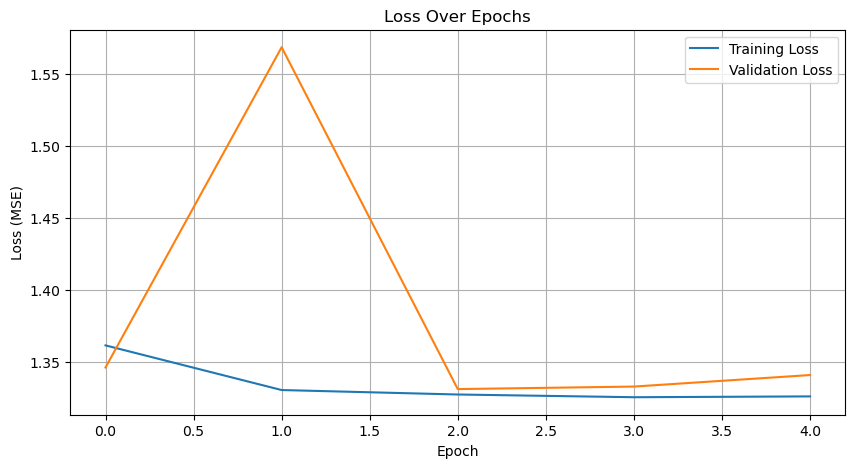

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ENCODER_DEPTH = 3
DECODER_CHANNELS = (128, 32, 16)
IN_CHANNELS = 1
OUT_CHANNELS = 1

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_depth=ENCODER_DEPTH,
    decoder_channels=DECODER_CHANNELS,
    in_channels=IN_CHANNELS,
    classes=OUT_CHANNELS,
).to(DEVICE)

LEARNING_RATE = 1e-2 
NUM_EPOCHS = 5
WEIGHT_DECAY = 1e-5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

def train_one_epoch(loader, model, optimizer, criterion, device, scaler):
    model.train()
    epoch_loss = 0
    if loader is None:
        print("Training loader is None, skipping training epoch.")
        return 0.0
    # Adjust unpacking to match the 5 items from the dataset
    for batch_idx, (noisy1, noisy2, _clean, _time_step, _config_name) in enumerate(loader): # CHANGED
        noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
        # _clean, _time_step, _config_name are unpacked but not used in this specific training step
        # If you need them later (e.g., for logging), you can use them.
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            denoised_output = model(noisy1)
            loss = criterion(denoised_output, noisy2) # Using noisy2 as target for Noise2Noise
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0: print(f"Train Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    if len(loader) == 0: return 0.0
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"End of Epoch, Avg Training Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

def validate_one_epoch(loader, model, criterion, device):
    model.eval()
    epoch_loss = 0
    if loader is None:
        print("Validation loader is None, skipping validation epoch.")
        return float('inf')
    with torch.no_grad():
        # Adjust unpacking to match the 5 items from the dataset
        for noisy1, noisy2, _clean, _time_step, _config_name in loader: # CHANGED
            noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
            # _clean, _time_step, _config_name are unpacked but not used here
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                denoised_output = model(noisy1)
                loss = criterion(denoised_output, noisy2) # Using noisy2 as target
            epoch_loss += loss.item()
    if len(loader) == 0: return float('inf')
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"Validation Avg Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

print("\nStarting training...")
train_losses, val_losses = [], []
best_val_loss = float('inf')

if train_loader is not None:
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_loss = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, scaler)
        train_losses.append(train_loss)
        val_loss = float('inf')
        if val_loader is not None:
            val_loss = validate_one_epoch(val_loader, model, criterion, DEVICE)
            val_losses.append(val_loss)
        
        save_path = f"model_epoch_{epoch+1}.pth"
        if val_loss < best_val_loss :
            if val_loader is not None: 
                 best_val_loss = val_loss
                 save_path = "best_denoising_model.pth"
                 print(f"Saved new best model with val_loss: {best_val_loss:.4f} to {save_path}")
        torch.save(model.state_dict(), save_path)
        if val_loader is None: print(f"Saved model checkpoint to {save_path} (no validation).")

else:
    print("Training cannot proceed as train_loader is not available.")

print("\nTraining finished!")

if train_losses or val_losses:
    plt.figure(figsize=(10,5))
    if train_losses: plt.plot(train_losses, label="Training Loss")
    if val_losses: plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)"); plt.title("Loss Over Epochs")
    plt.legend(); plt.grid(True); plt.show()


Loading best validation model for display from: best_denoising_model.pth

Displaying results from Test Set...


C:\Users\manav\AppData\Local\Temp\ipykernel_11096\3560921571.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locat

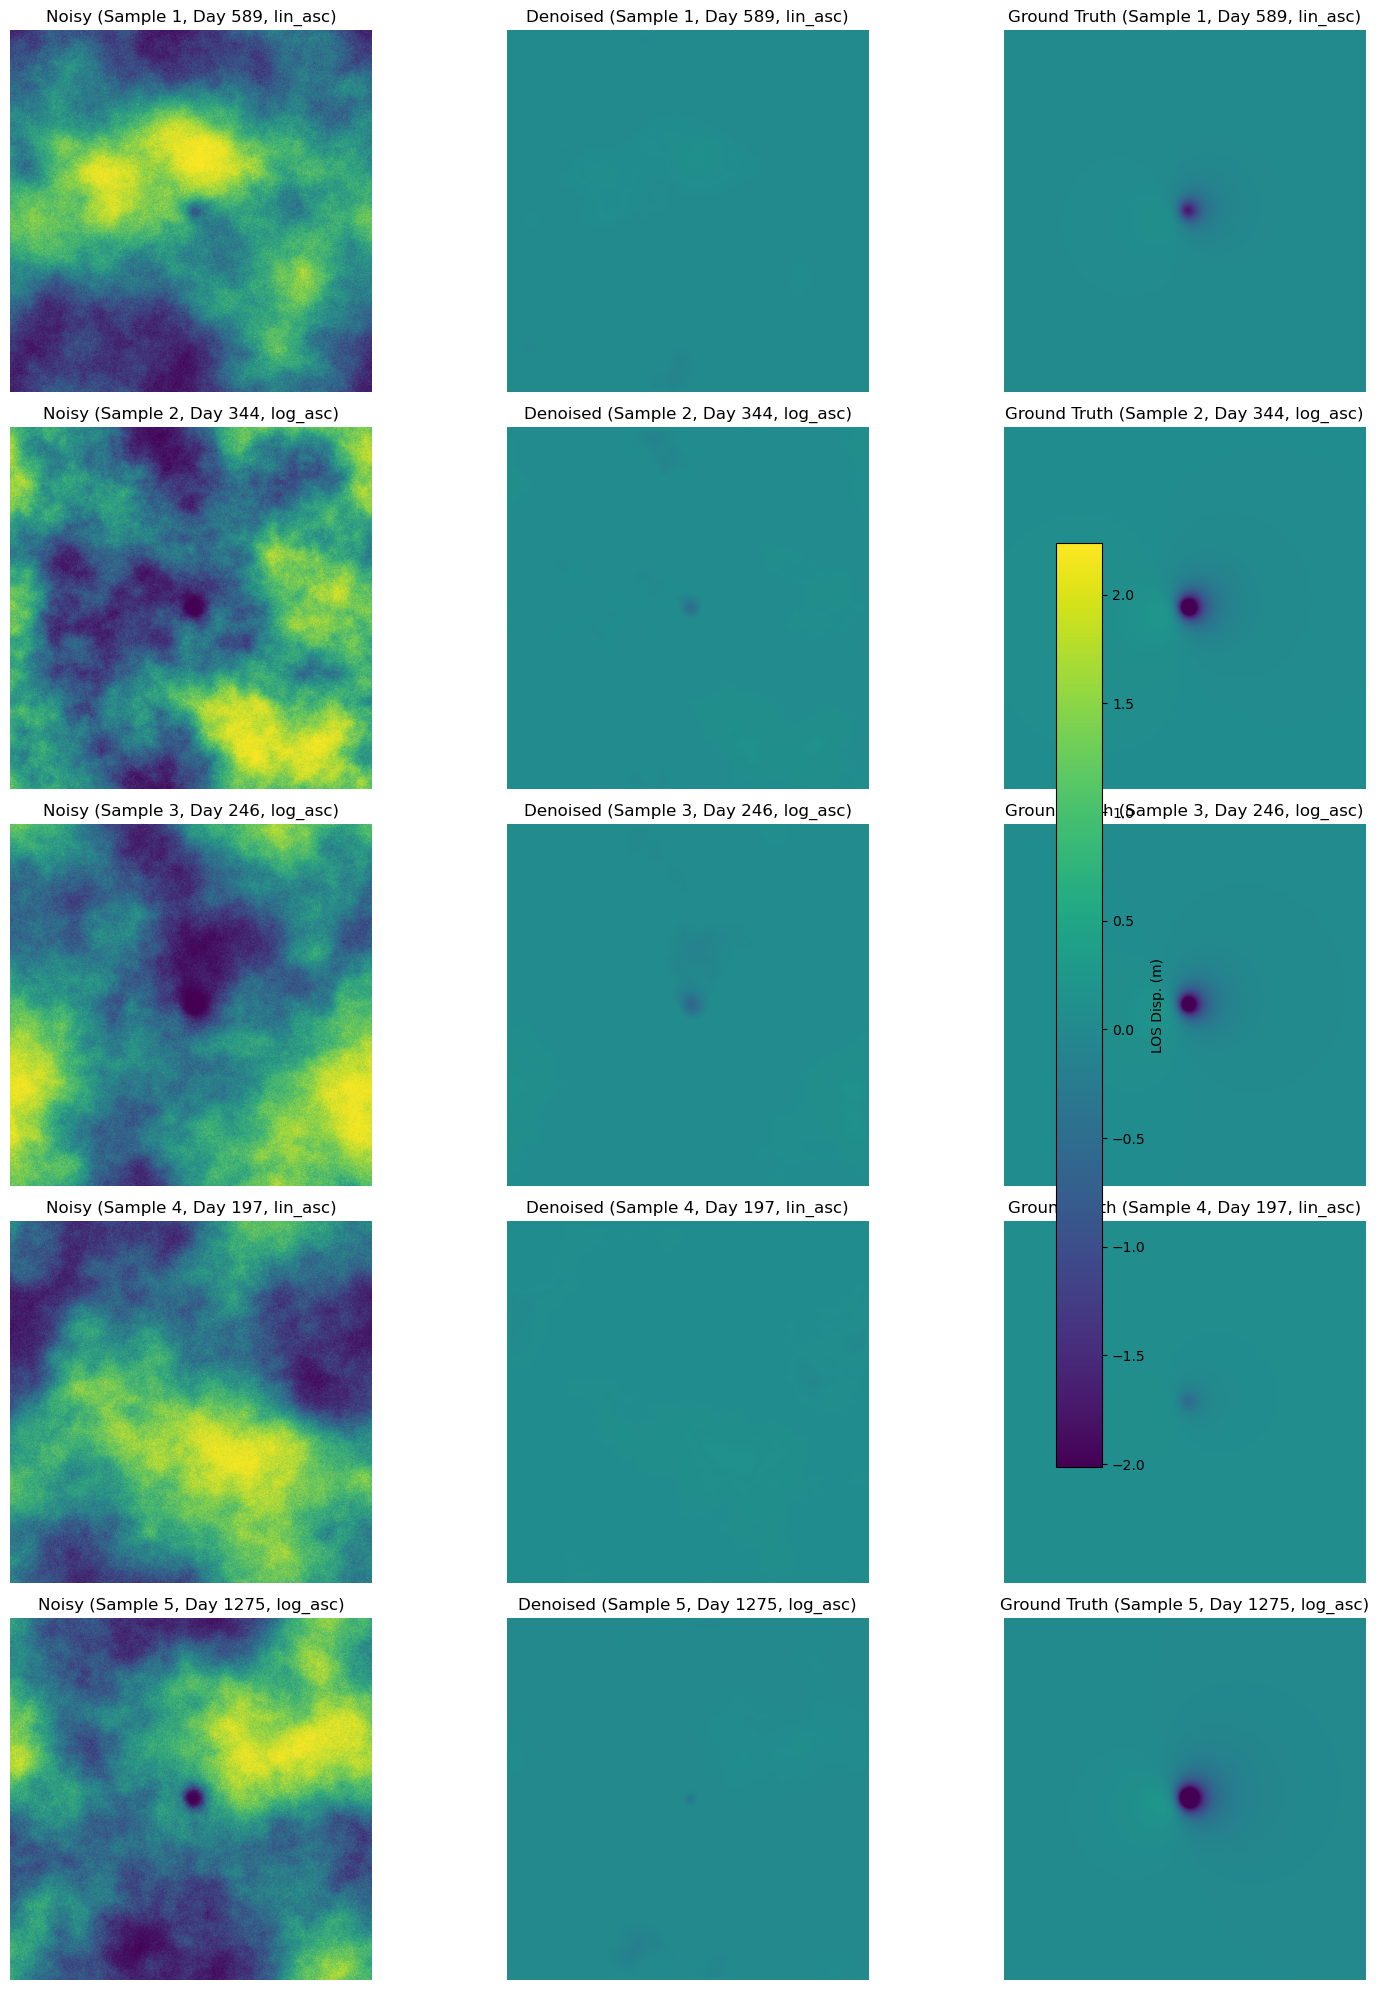

In [13]:
def display_results(model, data_loader, device, num_samples=5): # Consider if 5 is too many for large images
    if data_loader is None or len(data_loader) == 0:
        print("Data loader for display is None or empty. Skipping display.")
        return
    model.eval().to(device)
    data_iter = iter(data_loader) # Create an iterator

    # Adjust num_samples if it's larger than the dataset
    if num_samples > len(data_loader.dataset): # Access full dataset length if it's a Subset
        print(f"Warning: num_samples ({num_samples}) is greater than dataset size ({len(data_loader.dataset)}).")
        print(f"Adjusting num_samples to {len(data_loader.dataset)}.")
        num_samples = len(data_loader.dataset)
    if num_samples == 0:
        print("No samples to display.")
        return

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples)) # Increased width slightly
    if num_samples == 1: 
        axes = np.array([axes]) # Ensure axes is always 2D for consistent indexing

    with torch.no_grad():
        for i in range(num_samples):
            try:
                # Unpack the new metadata
                noisy_input, _, ground_truth, time_steps, config_names = next(data_iter)
                
                # If batch size is 1 (as it is in your setup), time_steps and config_names
                # will be iterables of length 1. Extract the first element.
                time_step = time_steps[0] if isinstance(time_steps, (list, torch.Tensor)) else time_steps
                config_name = config_names[0] if isinstance(config_names, list) else config_names

            except StopIteration: 
                print("Not enough samples in the data_loader to display the requested num_samples.")
                break # Exit the loop if we run out of data

            noisy_input = noisy_input.to(device)
            single_noisy_input = noisy_input[0:1] # Keep batch dim
            single_ground_truth = ground_truth[0].cpu().numpy().squeeze()
            denoised_output = model(single_noisy_input)
            single_denoised_output = denoised_output[0].cpu().numpy().squeeze()
            single_noisy_input_np = single_noisy_input[0].cpu().numpy().squeeze()

            all_vals = np.concatenate([
                single_noisy_input_np.ravel(), single_denoised_output.ravel(), single_ground_truth.ravel()
            ])
            vmin = np.percentile(all_vals, 1) 
            vmax = np.percentile(all_vals, 99)
            if vmin >= vmax: vmin, vmax = all_vals.min(), all_vals.max() # Fallback
            if vmin == vmax: vmin -= 0.1; vmax += 0.1 # Ensure range for flat data
            
            # --- Updated titles ---
            base_title = f"(Sample {i+1}, Day {time_step}, {config_name})"
            axes[i,0].set_title(f"Noisy {base_title}")
            axes[i,0].axis('off')
            im = axes[i,0].imshow(single_noisy_input_np,cmap='viridis',vmin=vmin,vmax=vmax)
            
            axes[i,1].set_title(f"Denoised {base_title}")
            axes[i,1].axis('off')
            im_denoised = axes[i,1].imshow(single_denoised_output,cmap='viridis',vmin=vmin,vmax=vmax) # Use a different variable for the imshow return if needed for colorbar
            
            axes[i,2].set_title(f"Ground Truth {base_title}")
            axes[i,2].axis('off')
            im_gt = axes[i,2].imshow(single_ground_truth,cmap='viridis',vmin=vmin,vmax=vmax) # Use a different variable

    if num_samples > 0 and 'im_gt' in locals():
        fig.colorbar(im_gt, ax=axes.ravel().tolist(), shrink=0.6, label='LOS Disp. (m)')
    
    plt.tight_layout()
    plt.show()

model_loaded_for_display = False
best_model_path = "best_denoising_model.pth"
last_epoch_model_path = f"model_epoch_{NUM_EPOCHS}.pth" if 'NUM_EPOCHS' in locals() else None

if os.path.exists(best_model_path):
    print(f"\nLoading best validation model for display from: {best_model_path}")
    try:
        model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
        model_loaded_for_display = True
    except Exception as e:
        print(f"Error loading best model: {e}")
elif last_epoch_model_path and os.path.exists(last_epoch_model_path):
    print(f"\nBest validation model not found. Loading model from last epoch: {last_epoch_model_path}")
    try:
        model.load_state_dict(torch.load(last_epoch_model_path, map_location=DEVICE))
        model_loaded_for_display = True
    except Exception as e:
        print(f"Error loading last epoch model: {e}")
else:
    print("\nNo saved model weights found (checked for 'best_denoising_model.pth' and last epoch model).")
    print("Using current model state for display (if any training was done in this session).")
    if 'NUM_EPOCHS' in locals() and NUM_EPOCHS > 0 : # If training was supposed to happen
         model_loaded_for_display = True # Assume current model state is what we want to display
    elif 'NUM_EPOCHS' in locals() and NUM_EPOCHS == 0: # No training intended
         model_loaded_for_display = True

should_display = model_loaded_for_display or ('NUM_EPOCHS' in locals() and NUM_EPOCHS == 0)

if should_display:
    if test_loader is not None and len(test_loader) > 0:
        print("\nDisplaying results from Test Set...")
        display_results(model, test_loader, DEVICE)
    elif val_loader is not None and len(val_loader) > 0:
        print("\nTest Set empty or unavailable. Displaying results from Validation Set...")
        display_results(model, val_loader, DEVICE)
    elif train_loader is not None and len(train_loader) > 0:
        print("\nTest and Validation Sets empty or unavailable. Displaying results from Training Set...")
        display_results(model, train_loader, DEVICE)
    else:
        print("All data loaders are empty. Cannot display results.")
else:
    print("\nModel not loaded and no conditions met to display results.")